# One cell capacity

In [1]:
from __future__ import print_function
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

#### Git capacity

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = '1e99cfe7b1982691a0212334a93d58057df83d56'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

#### Load libraries

In [3]:
from network import BCPNN, NetworkManager, BCPNNFast, Protocol
from data_transformer import build_ortogonal_patterns

from plotting_functions import plot_winning_pattern, plot_sequence
from analysis_functions import calculate_recall_success, calculate_timings

## An example

In [4]:
# Patterns parameters
hypercolumns = 4
minicolumns = 50

# Manager properties
dt = 0.001
T_recall = 3.0
values_to_save = ['o']

# Protocol
training_time = 0.1
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

# Build the network
nn = BCPNNFast(hypercolumns, minicolumns)
nn.k_inner = False

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for
protocol = Protocol()
sequence1 = [0, 1, 10, 3, 4]
sequence2 = [5, 6, 10, 7, 8]
sequence3 = [11, 12, 10, 13, 14]
chain = [sequence1, sequence2, sequence3]
protocol.cross_protocol(chain, training_time=training_time, inter_sequence_interval=inter_sequence_interval,
                        epochs=epochs)

# Train
manager.run_network_protocol(protocol, verbose=False, values_to_save_epoch=None, reset=True, empty_history=True)



../analysis_functions.py:43: RuntimeWarning: invalid value encountered in double_scalars
  dis = [a / b for (a, b) in zip(nominator, denominator)]


[(0, 0.33000000000000002, 0.0, 0.32900000000000001), (1, 0.53800000000000003, 0.32900000000000001, 0.86599999999999999), (10, 0.28200000000000003, 0.86599999999999999, 1.147), (3, 0.53700000000000003, 1.147, 1.6830000000000001), (4, 0.63100000000000001, 1.6830000000000001, 2.3130000000000002), (5, 0.78700000000000003, 2.3130000000000002, 3.0990000000000002), (5, 0.33600000000000002, 3.1000000000000001, 3.4350000000000001), (6, 0.48699999999999999, 3.4350000000000001, 3.9210000000000003), (10, 0.29199999999999998, 3.9210000000000003, 4.2119999999999997), (7, 0.55200000000000005, 4.2119999999999997, 4.7629999999999999), (8, 0.58199999999999996, 4.7629999999999999, 5.3440000000000003), (11, 0.41200000000000003, 5.3440000000000003, 5.7549999999999999), (11, 0.014, 5.758, 5.7709999999999999), (11, 0.041000000000000002, 5.7789999999999999, 5.819), (11, 0.025000000000000001, 5.8220000000000001, 5.8460000000000001), (0, 0.35499999999999998, 5.8460000000000001, 6.2000000000000002), (11, 0.34300

../plotting_functions.py:84: RuntimeWarning: invalid value encountered in less
  angles[angles < 0.1] = 0


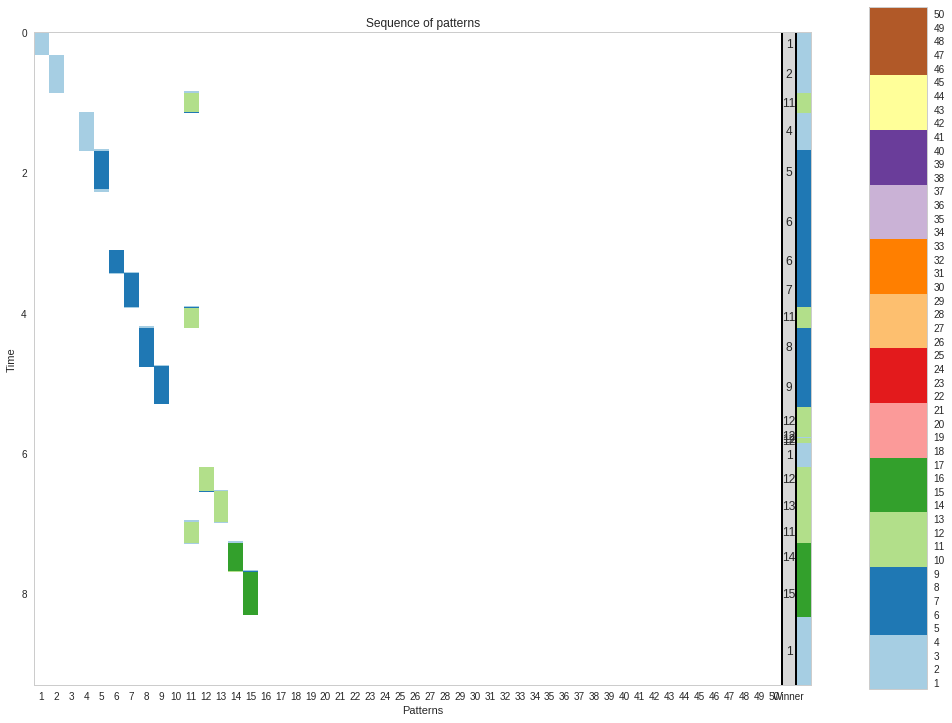

In [5]:
manager.run_network_recall(T_recall=T_recall, T_cue=0.1, I_cue=0, reset=True, empty_history=True)
manager.run_network_recall(T_recall=T_recall, T_cue=0.1, I_cue=5, reset=True, empty_history=False)
manager.run_network_recall(T_recall=T_recall, T_cue=0.1, I_cue=11, reset=True, empty_history=False)

# Timings
timings = calculate_timings(manager, remove=0.010)
print(timings)

plot_winning_pattern(manager, remove=0.010)

### Systematic study
#### Number of minicolumns

In [6]:
# Patterns parameters
hypercolumns = 4
minicolumns_range = np.arange(20, 60, 5)

# Manager properties
dt = 0.001
T_recall = 3.0
values_to_save = ['o']

# Protocol
training_time = 0.1
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

# Build the protocol for
protocol = Protocol()
sequence1 = [0, 1, 10, 3, 4]
sequence2 = [5, 6, 10, 7, 8]
sequence3 = [11, 12, 10, 13, 14]
chain = [sequence1, sequence2, sequence3]
protocol.cross_protocol(chain, training_time=training_time, inter_sequence_interval=inter_sequence_interval,
                        epochs=epochs)

In [7]:
n = 10
success_array = np.zeros((len(chain), minicolumns_range.size))
for minicolumn_index, minicolumns in enumerate(minicolumns_range):
    
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns)
    nn.k_inner = False

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Train
    manager.run_network_protocol(protocol, verbose=False, values_to_save_epoch=None, reset=True, empty_history=True)
    
    # Test recall
    for sequence_index, sequence in enumerate(chain):
        success = calculate_recall_success(manager, T_recall=T_recall, I_cue=sequence[0], T_cue=0.1, n=n,
                                        patterns_indexes=sequence)
        success_array[sequence_index, minicolumn_index] = success

20
25
30
35
40
45
50
55


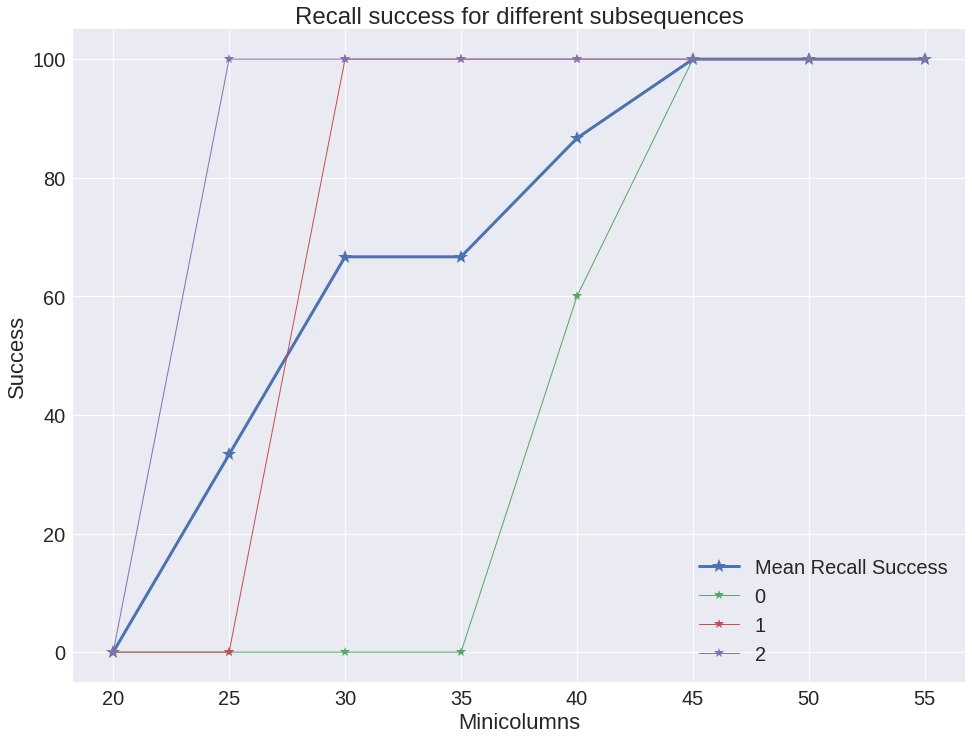

In [8]:
sns.set(font_scale=2.0)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.plot(minicolumns_range, np.mean(success_array, axis=0), '*-', markersize=14, linewidth=3, label='Mean Recall Success')

for sequence_index in range(len(chain)):
    ax.plot(minicolumns_range, success_array[sequence_index, :], '*-', markersize=10, linewidth=1, label=str(sequence_index))
    
ax.legend()
ax.set_ylim([-5, 105])
ax.set_xlabel('Minicolumns')
ax.set_ylabel('Success')
ax.set_title('Recall success for different subsequences')

In [6]:
# Patterns parameters
hypercolumns = 4
minicolumns_range = np.arange(20, 60, 5)

# Manager properties
dt = 0.001
T_recall = 3.0
values_to_save = ['o']

# Protocol
training_time = 0.1
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

# Build the protocol for
protocol = Protocol()
sequence1 = [0, 1, 10, 3, 4]
sequence2 = [5, 6, 10, 7, 8]
sequence3 = [11, 12, 10, 13, 14]
chain = [sequence1, sequence2, sequence3]
protocol.cross_protocol(chain, training_time=training_time, inter_sequence_interval=inter_sequence_interval,
                        epochs=epochs)

In [7]:
n = 10
success_array = np.zeros((len(chain), minicolumns_range.size))
for minicolumn_index, minicolumns in enumerate(minicolumns_range):
    
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns)
    nn.k_inner = False

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Train
    manager.run_network_protocol(protocol, verbose=False, values_to_save_epoch=None, reset=True, empty_history=True)
    
    # Test recall
    for sequence_index, sequence in enumerate(chain):
        success = calculate_recall_success(manager, T_recall=T_recall, I_cue=sequence[0], T_cue=0.1, n=n,
                                        patterns_indexes=sequence)
        success_array[sequence_index, minicolumn_index] = success

20
25
30
35
40
45
50
55


In [ ]:
sns.set(font_scale=2.0)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.plot(minicolumns_range, np.mean(success_array, axis=0), '*-', markersize=14, linewidth=3, label='Mean Recall Success')

for sequence_index in range(len(chain)):
    ax.plot(minicolumns_range, success_array[sequence_index, :], '*-', markersize=10, linewidth=1, label=str(sequence_index))
    
ax.legend()
ax.set_ylim([-5, 105])
ax.set_xlabel('Minicolumns')
ax.set_ylabel('Success')
ax.set_title('Recall success for different subsequences')

#### Same but with more sequences

In [9]:
# Patterns parameters
hypercolumns = 4
minicolumns_range = np.arange(40, 80, 10)

# Manager properties
dt = 0.001
T_recall = 3.0
values_to_save = ['o']

# Protocol
training_time = 0.1
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

protocol = Protocol()
sequence1 = [0, 1, 10, 3, 4]
sequence2 = [5, 6, 10, 7, 8]
sequence3 = [11, 12, 10, 13, 14]
sequence4 = [15, 16, 10, 17, 18]
sequence5 = [19, 20, 10, 21, 22]

chain = [sequence1, sequence2, sequence3, sequence4, sequence5]
protocol.cross_protocol(chain, training_time=training_time, inter_sequence_interval=inter_sequence_interval,
                        epochs=epochs)

In [10]:
n = 10
success_array = np.zeros((len(chain), minicolumns_range.size))
for minicolumn_index, minicolumns in enumerate(minicolumns_range):
    print(minicolumn_index)
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns)
    nn.k_inner = False

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Train
    manager.run_network_protocol(protocol, verbose=False, values_to_save_epoch=None, reset=True, empty_history=True)
    
    # Test recall
    for sequence_index, sequence in enumerate(chain):
        success = calculate_recall_success(manager, T_recall=T_recall, I_cue=sequence[0], T_cue=0.1, n=n,
                                        patterns_indexes=sequence)
        success_array[sequence_index, minicolumn_index] = success

0
1
2
3


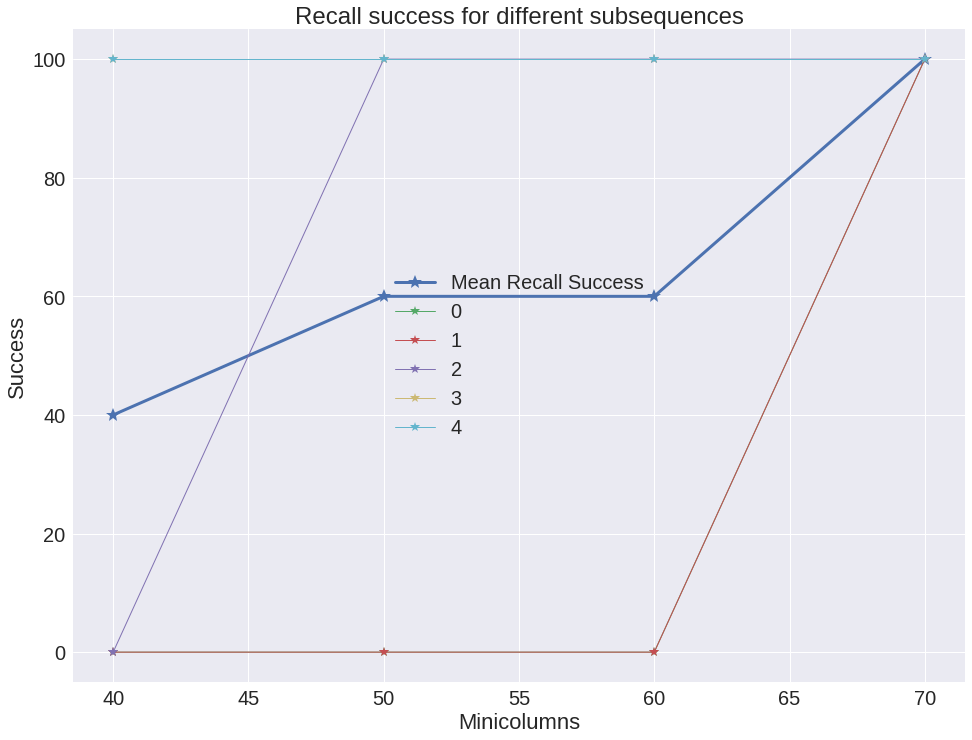

In [11]:
sns.set(font_scale=2.0)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.plot(minicolumns_range, np.mean(success_array, axis=0), '*-', markersize=14, linewidth=3, label='Mean Recall Success')

for sequence_index in range(len(chain)):
    ax.plot(minicolumns_range, success_array[sequence_index, :], '*-', markersize=10, linewidth=1, label=str(sequence_index))
    
ax.legend()
ax.set_ylim([-5, 105])
ax.set_xlabel('Minicolumns')
ax.set_ylabel('Success')
ax.set_title('Recall success for different subsequences')